# Plan d'expériences de désactivation des enzymes
Valentine a réalisé un plan d'expériences. (Une série de conditions) et a enregistré les réponses (résultats de dosages))

L'enjeu de la manip est :
1. Modeliser (Trouver une équation que relie les différents paramètres étudiés et les résultats obtenus pour chaque réponse)
2. Evaluer la qualité des modèles
2. Trouver les paramètres pour lesquels on desactive les enzymes c'est-à-dire minimiser la valeur des réponses

# 0. Préliminaire

Dans un terminal (Ctrl+Maj+ù), taper:

    pip install lestpy --upgrade

Verifier que la version est bien la 0.0.8 (si j'ai le temps d'exporter mes correctifs sinon 0.0.7 mais l'analyse de sensitilité de fonctionnera pas), sinon relancer ce script

ou si ce n'est pas installé (il faut egalement avoir installé numpy, pandas, statsmodels, scipy, SALib et sklearn)

    pip install lestpy

# 1. Import des modules

+ Modules Pandas pour la gestion des tableaux
+ Modules Lestpy pour la modélisation

In [1]:
import pandas as pd
import lestpy.lbm_model as lp

# 2. Import des données

### Obtenir le chemin d'accès au fichier de données:
Enregistrer les données à l'endroit souhaité.

Faire clique-droit sur le fichier et cliquer sur: 

    copier en tant que chemin d'accès
    

### Définition du chemin et nom du fichier de données

<!> au sens des slashs pour le chemin ! Windows met les anti-slashs \\ qu'il faut corriger en /S

In [2]:
path, fichier = "C:/Users/TTfr/Documents/Python/Analyses DOE - MD/desactivation/","resultats DOE Val.xlsx"

### Import des données dans python avec pandas
import et visualisation des 5 premieres lignes avec .head(5)

In [3]:
donnees = pd.read_excel(path + fichier, decimal=',')
donnees.head(5)

,Unnamed: 0,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)],X10 1,C3 1570,X10 1500/1,C1 1500/1,Hel1,C3 0614/2,PR1 FL,PR1 0120/1
0,0,3,50,15,5,0.503600,0.541167,0.574600,0.624733,0.705133,0.722133,0.041933,0.000000
1,1,9,50,15,5,0.634000,0.661000,0.540000,0.503000,0.440000,0.430000,0.107617,0.033583
2,2,3,80,15,5,0.018733,0.551333,0.104033,0.137800,0.043533,0.681500,0.029317,0.032650
3,3,9,80,15,5,0.089767,0.048667,0.473533,0.354233,0.398967,0.981267,0.000000,0.009533
4,4,3,65,5,5,0.515650,0.379983,0.464750,0.520250,0.589483,0.520817,0.040733,0.000333


### Nettoyage des données et des colonnes obsolètes
la première colonne est inutile donc on la laisse tomber (.drop() ) défitinivement (inplace = True)

Et on visualise les 5 dernières lignes ( .tail(5) )

In [4]:
donnees.drop(columns = donnees.columns[0], inplace=True)
donnees.tail(5)

,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)],X10 1,C3 1570,X10 1500/1,C1 1500/1,Hel1,C3 0614/2,PR1 FL,PR1 0120/1
25,6,65,15,5,0.383933,0.198000,0.438200,0.303567,0.444400,0.735933,0.004800,0.004800
26,6,65,15,5,0.436600,0.555767,0.462100,0.354133,0.551400,0.491900,0.005733,0.000000
27,6,65,15,0,0.024467,0.028133,0.088533,0.121500,0.029400,0.363033,0.024467,0.028133
28,6,65,15,0,0.008700,0.021750,0.040350,0.090100,0.015050,0.408650,0.036450,0.022100
29,6,65,15,0,0.074867,0.035433,0.087633,0.263000,0.018733,0.554067,0.000000,0.018767


### Liste des colonnes pour séparer entre X et y

In [5]:
donnees.columns

Index(['pH', 'Temperatures (°C)', 'Temps (min)', '[Acide pectique (%m/m)]',
       'X10 1', 'C3 1570', 'X10 1500/1', 'C1 1500/1', 'Hel1', 'C3 0614/2',
       'PR1 FL', 'PR1 0120/1'],
      dtype='object')

### Définition des paramètres descriptifs X et des réponses y

et visualisation d'un descriptif de chaque tableau avec .describe()

In [6]:
y = donnees[['X10 1','C3 1570', 'X10 1500/1', 'C1 1500/1', 'Hel1', 'C3 0614/2', 'PR1 FL', 'PR1 0120/1']]
X = donnees[['pH', 'Temperatures (°C)', 'Temps (min)', '[Acide pectique (%m/m)]']]
X.describe()

,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)]
count,30.000000,30.000000,30.000000,30.000000
mean,6.000000,65.000000,15.000000,4.500000
std,1.929803,9.649013,6.432675,3.559833
min,3.000000,50.000000,5.000000,0.000000
25%,6.000000,65.000000,15.000000,0.000000
50%,6.000000,65.000000,15.000000,5.000000
75%,6.000000,65.000000,15.000000,5.000000
max,9.000000,80.000000,25.000000,10.000000


In [7]:
y.describe()

,X10 1,C3 1570,X10 1500/1,C1 1500/1,Hel1,C3 0614/2,PR1 FL,PR1 0120/1
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.241699,0.304953,0.366014,0.312658,0.325755,0.622103,0.031070,0.014003
std,0.223307,0.277782,0.221870,0.230424,0.262418,0.329777,0.031024,0.023213
min,0.000000,0.001567,0.000000,-0.000067,0.008500,0.000000,0.000000,0.000000
25%,0.034629,0.032583,0.151567,0.139794,0.051042,0.433017,0.006933,0.000000
50%,0.164609,0.246000,0.421317,0.301950,0.376717,0.593017,0.018258,0.002417
75%,0.443250,0.554658,0.512100,0.428383,0.511567,0.809621,0.041758,0.018250
max,0.634000,0.891900,0.756100,1.079517,0.881633,1.342567,0.107617,0.085167


# 3. Modelisation

### création d'un modèle par l'approche Lestpy 

In [8]:
model = lp.LBM_Regression()

### Premier essai - Modelisation linéaire
reponse = coef1 * pH + coef2 * T°C + coef3 * temps, etc.

Les valeurs *R-squared* pour chaque modèle sont faibles (maximum à 50%) montrant que les facteurs simples ne sont pas suffisants pour expliquer les variations des réponses.

Ce résultat est plutot conforme aux attentes. En effet, les enzymes ont un pH optimal et une temperature optimale, l'activité n'augmente donc pas avec l'augmentation de la température ou du pH par exemple. 

In [9]:
model.fit(X,y)

summary of the model for X10 1:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     5.122
Date:                Wed, 25 May 2022   Prob (F-statistic):            0.00644
Time:                        14:17:13   Log-Likelihood:                 9.8826
No. Observations:                  30   AIC:                            -11.77
Df Residuals:                      26   BIC:                            -6.160
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.009

### Calcul de nouvelles variables 'interactions'
on calcule ces interactions en appelant la méthode .transform(X,y)


In [10]:
model.transform(X, y)

['X_xor_Y', 'X_or_Y', 'X_or_not_Y', 'X_and_Y', 'X_and_not_Y', 'X_if_Y', 'X_if_not_Y', 'X_if_Y_average', 'X_average_if_Y', 'Neither_X_nor_Y_extreme', 'both_X_Y_average', 'X_like_Y', 'Sum_X_Y', 'Difference_X_Y']
method = variable instant
calculated in 0.318 seconds


La liste affichée *['X_xor_Y', 'X_or_Y'...]* correspond aux interactions utilisées.


Le tableau est maintenant composé des facteurs simples mais aussi d'interactions entre ceux-ci

### Second essai - modélisation avec interactions
Les valeurs *R-squared* sont maintenant bien meilleures. A une exception près (modele 'C3 1570') les valeurs sont supérieures à 85% 

In [11]:
model.fit()

summary of the model for X10 1:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     12.18
Date:                Wed, 25 May 2022   Prob (F-statistic):           2.46e-06
Time:                        14:17:15   Log-Likelihood:                 30.954
No. Observations:                  30   AIC:                            -41.91
Df Residuals:                      20   BIC:                            -27.90
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.431

#### On peut afficher l'expression exactes des différents modèles avec la methode .print_model()

In [12]:
model.print_model()

model for target "X10 1"
The value of X10 1 is high if:
   Coefficient                                          Parameter  Std Error
0       -0.432   Temperatures (°C) or not [Acide pectique (%m/m)]      0.135
1       -0.658                    pH if Temperatures (°C) average      0.110
2       -0.477               Temperatures (°C) or not Temps (min)      0.137
3       -0.353              both pH and Temperatures (°C) average      0.106
4       -0.679           Temperatures (°C) if Temps (min) average      0.181
5        0.686               Sum of pH and Temperatures (°C) high      0.219
6        0.203  both Temps (min) and [Acide pectique (%m/m)] a...      0.105
7       -0.184            Temps (min) xor [Acide pectique (%m/m)]      0.104
8       -0.170                     pH xor [Acide pectique (%m/m)]      0.104



model for target "C3 1570"
The value of C3 1570 is high if:
   Coefficient                                          Parameter  Std Error
0       -1.211                    

#### On peut avoir un résumé des scores d'ajustement des différents modèles avec la methode .fitting_score()

In [13]:
for i in y:
    model.fitting_score(y[i])

Fitting score for target "X10 1"
                R²  adj-R²  calc-Q²
model score  0.846   0.777    0.639
Fitting score for target "C3 1570"
                R²  adj-R²  calc-Q²
model score  0.619    0.52    0.378
Fitting score for target "X10 1500/1"
                R²  adj-R²  calc-Q²
model score  0.909   0.861    0.754
Fitting score for target "C1 1500/1"
                R²  adj-R²  calc-Q²
model score  0.857   0.782    0.613
Fitting score for target "Hel1"
                R²  adj-R²  calc-Q²
model score  0.892   0.835    0.734
Fitting score for target "C3 0614/2"
                R²  adj-R²  calc-Q²
model score  0.898   0.859    0.739
Fitting score for target "PR1 FL"
                R²  adj-R²  calc-Q²
model score  0.936   0.902    0.882
Fitting score for target "PR1 0120/1"
                R²  adj-R²  calc-Q²
model score  0.917   0.891    0.856


# 4. Visualisation des différentes modélisations

On visualisera différents élements en créant une instance de la classe Display() et en passant notre modèle en paramètre

In [14]:
graf = lp.Display(model)

## 4.1 Une première méthode consiste à imprimer un descriptif des modèles.
Le descriptif comprend:
1. les scores d'ajustement
2. le graph d'ajustement (y modélisé en fonction de y mesuré)
3. la distribution des résidus
4. Le graphique d'optimisation du R2 de prédiction = Q2 en fonction du nombre de facteurs dans le modèle (l'idée etant de maximiser le Q2 et minimiser le nombre de facteurs)

Fitting score for target "X10 1"
                R²  adj-R²  calc-Q²
model score  0.846   0.777    0.639


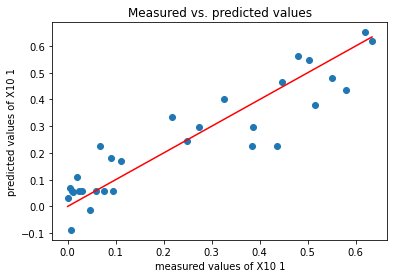

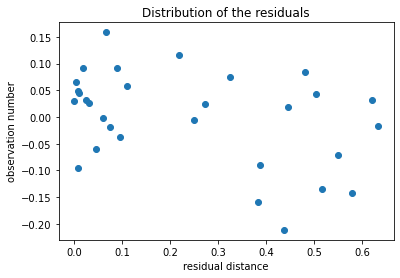

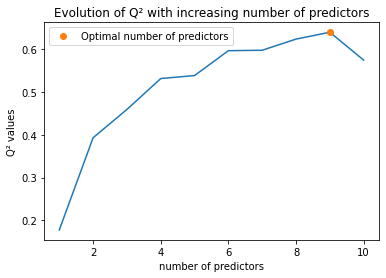

Fitting score for target "C3 1570"
                R²  adj-R²  calc-Q²
model score  0.619    0.52    0.378


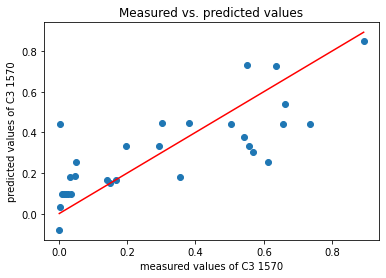

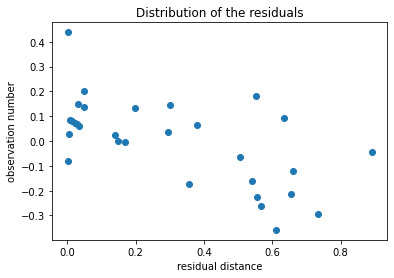

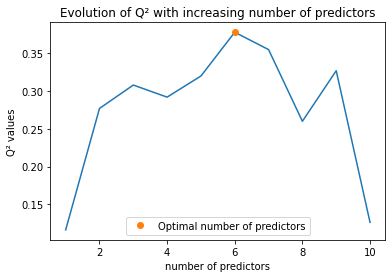

Fitting score for target "X10 1500/1"
                R²  adj-R²  calc-Q²
model score  0.909   0.861    0.754


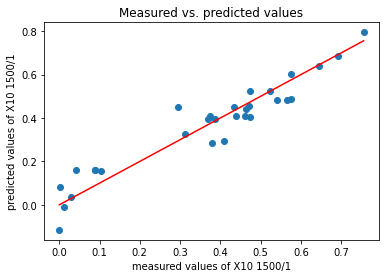

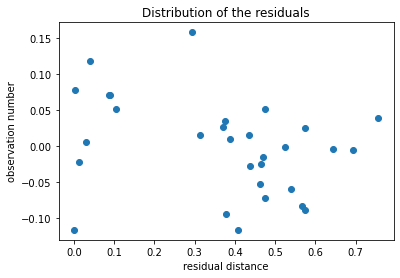

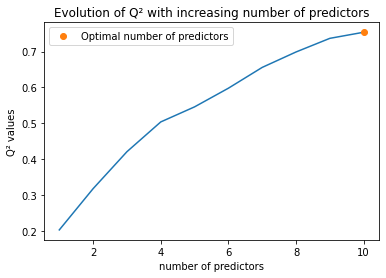

Fitting score for target "C1 1500/1"
                R²  adj-R²  calc-Q²
model score  0.857   0.782    0.613


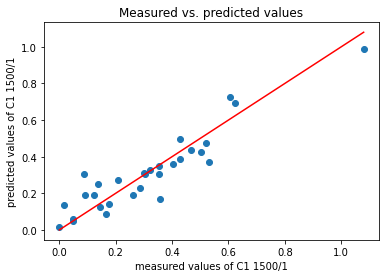

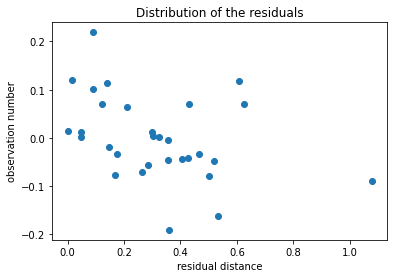

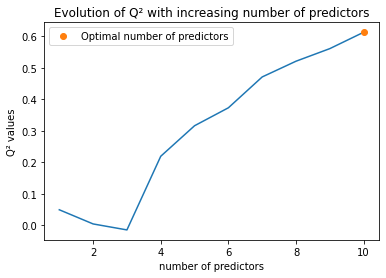

Fitting score for target "Hel1"
                R²  adj-R²  calc-Q²
model score  0.892   0.835    0.734


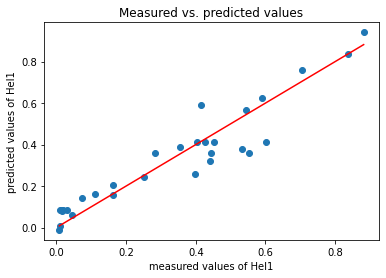

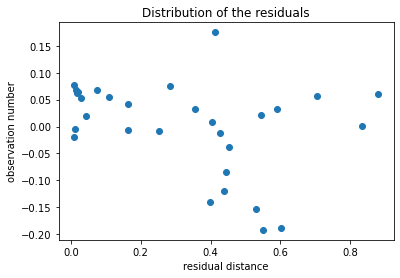

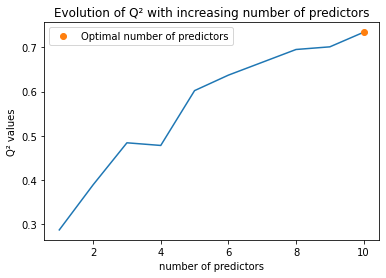

Fitting score for target "C3 0614/2"
                R²  adj-R²  calc-Q²
model score  0.898   0.859    0.739


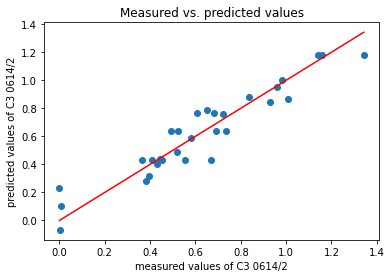

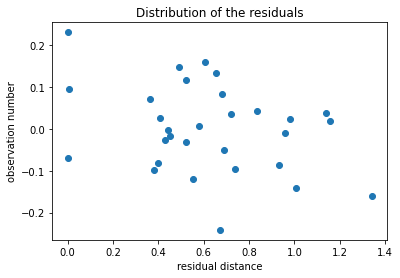

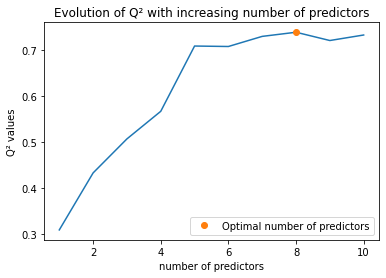

Fitting score for target "PR1 FL"
                R²  adj-R²  calc-Q²
model score  0.936   0.902    0.882


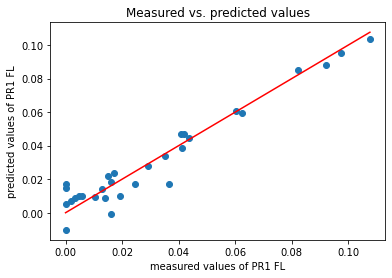

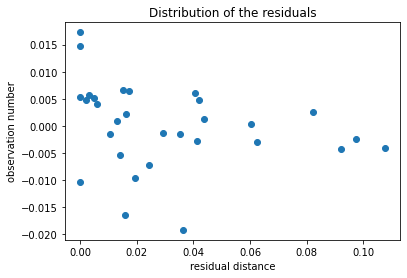

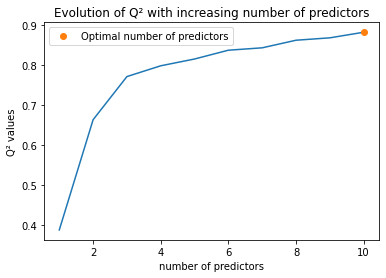

Fitting score for target "PR1 0120/1"
                R²  adj-R²  calc-Q²
model score  0.917   0.891    0.856


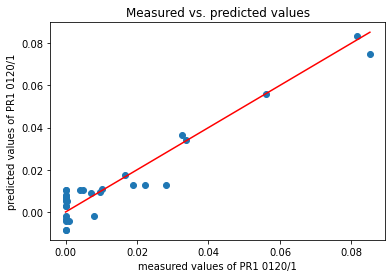

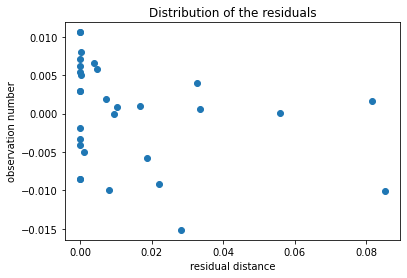

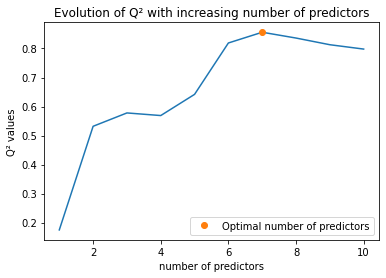

In [15]:
graf.describe()

## 4.2 Domaine experimental
On décrit d'abord le domaine expérimental (= le cadre) dans lequel aura lieu l'optimisation (quelle gamme de pH, de temp, etc.)
On a accès à une méthode automatisée .feature_analysis() qui renvoie le domaine expérimental analysée, le mélange (mix) si il y a un mélange

domain est un dictionnaire dont les clés sont les facteurs et les valeurs sont une liste comprenant :
+ [statut (inutile à ce stage), minimum, maximum, [valeurs si variable], type de variable (discrète ou continue)]

In [16]:
domain, mix = model.features_analysis(X)

## 4.3 Analyse de sensibilité
L'objectif est de voir à quel point les variation des variables seules ou en interactions sont impactantes sur la valeur finale du modèle

Sensitivity analysis for response X10 1


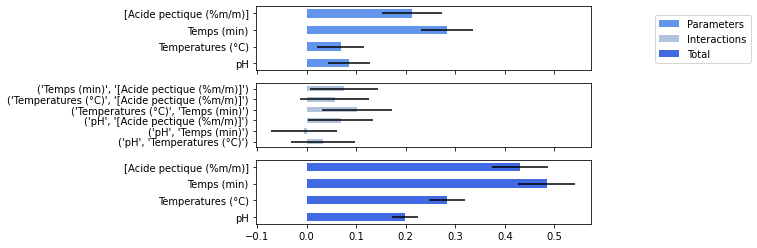

Sensitivity analysis for response C3 1570


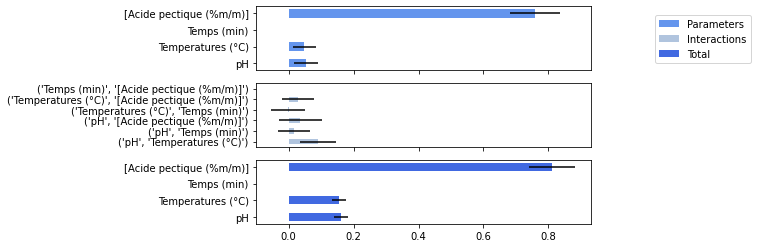

Sensitivity analysis for response X10 1500/1


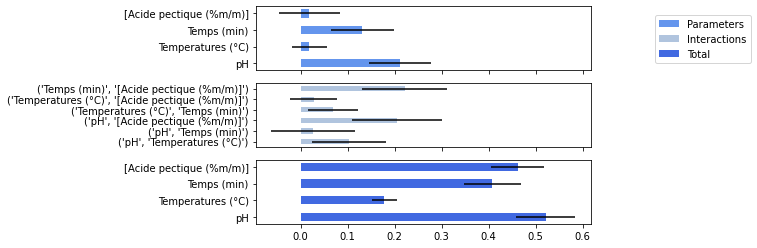

Sensitivity analysis for response C1 1500/1


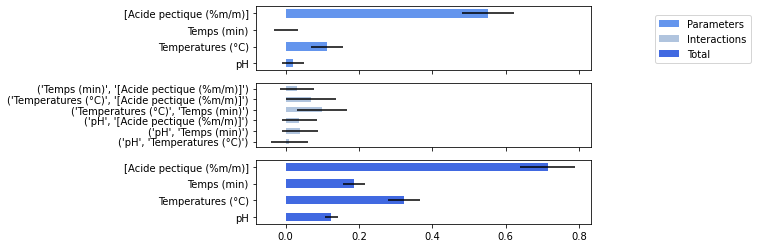

Sensitivity analysis for response Hel1


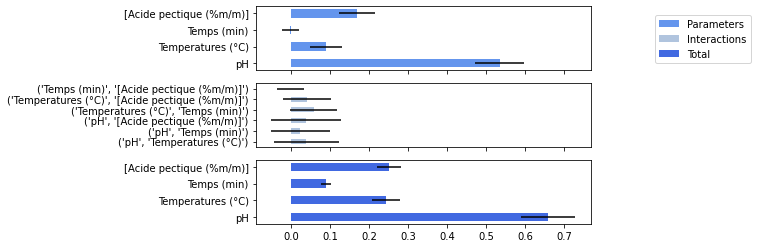

Sensitivity analysis for response C3 0614/2


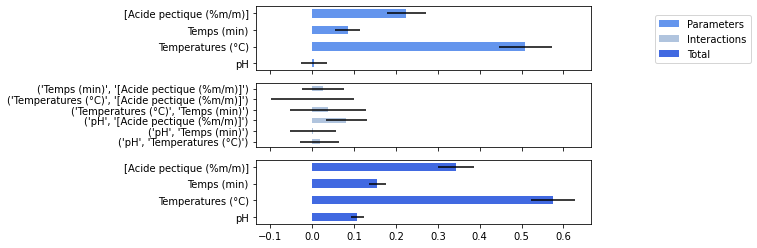

Sensitivity analysis for response PR1 FL


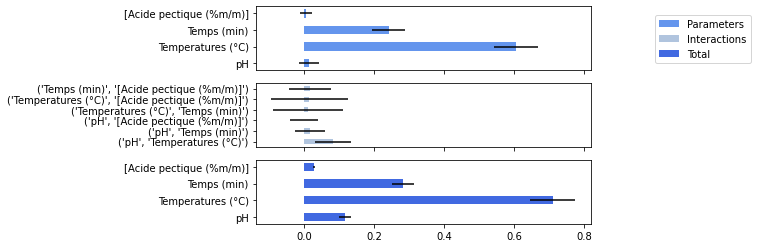

Sensitivity analysis for response PR1 0120/1


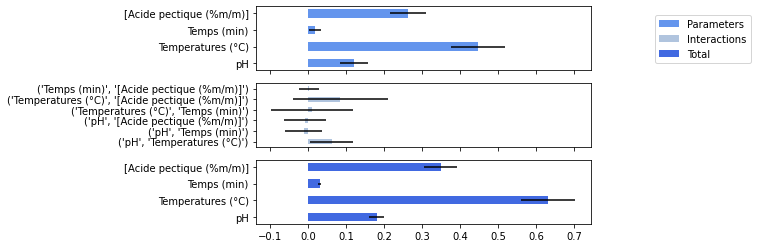

In [17]:
graf.sensibility_analysis(domain)

## 5. Optimisation

L'objectif de cette manip est de trouver les conditions idéales selon le modèle pour minimiser l'activité des enzymes donc maximiser la desactivation

In [18]:
domain, mix = model.features_analysis(X)
print(domain)

{'pH': [None, 3, 9, [3, 9, 6], 'discrete'], 'Temperatures (°C)': [None, 50, 80, [50, 80, 65], 'discrete'], 'Temps (min)': [None, 5, 25, [15, 5, 25], 'discrete'], '[Acide pectique (%m/m)]': [None, 0, 10, [5, 0, 10], 'discrete']}


## 5.2 Definition des objectifs
Les objectifs sont une liste qui décrit pour chaque variable dans l'ordre l'objectif d'optimisation que l'on souhaite parmi:
minimisation, maximisation, valeur à atteindre ou aucun objectif

Ici on souhaite minimiser toutes les réponses donc on crée une liste de 8 'minimize' car il y a 8 modèles

In [19]:
target = ['minimize'] * 8
print(target)

['minimize', 'minimize', 'minimize', 'minimize', 'minimize', 'minimize', 'minimize', 'minimize']


## 5.3 Minimisation globale
On lance l'optimisation avec la méthode .optimize() dans laquelle on injecte le domaine experimental et les objectifs.

In [20]:
model.optimize(domain, target)

size = 10000
                         Mean of the 5 best results  Best result
pH                                            9.000        9.000
Temperatures (°C)                            65.000       65.000
Temps (min)                                  25.000       25.000
[Acide pectique (%m/m)]                       0.000        0.000
PredX10 1                                    -0.090       -0.090
PredC3 1570                                  -0.079       -0.079
PredX10 1500/1                               -0.135       -0.135
PredC1 1500/1                                 0.004        0.004
PredHel1                                     -0.345       -0.345
PredC3 0614/2                                 0.097        0.097
PredPR1 FL                                    0.025        0.025
PredPR1 0120/1                               -0.002       -0.002
desirability                                  0.781        0.781


,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)],PredX10 1,PredC3 1570,PredX10 1500/1,PredC1 1500/1,PredHel1,PredC3 0614/2,PredPR1 FL,PredPR1 0120/1,desirability
0,6,50,15,0,0.334328,0.150334,0.327705,0.127048,0.243665,0.282465,0.095185,0.083250,0.437180
1,3,80,5,0,0.441297,0.417722,0.397819,0.930989,0.822690,1.247246,0.065982,0.016978,0.324507
2,3,50,15,5,0.546460,0.378421,0.486847,0.694038,0.761238,0.756602,0.046746,0.007133,0.377913
3,9,65,25,5,0.169676,0.253191,0.452853,0.386634,0.141655,0.787450,0.038517,-0.004135,0.544081
4,9,50,25,0,0.133782,0.152517,0.088190,-0.214208,-0.651514,-0.320723,0.110776,0.074375,0.552233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,6,65,15,5,0.225363,0.331564,0.410509,0.307779,0.359421,0.638983,0.009870,0.010590,0.539995
9996,6,50,15,10,0.651418,0.728341,0.640507,0.990642,0.837219,0.878121,0.060618,0.009183,0.252250
9997,9,65,25,5,0.169676,0.253191,0.452853,0.386634,0.141655,0.787450,0.038517,-0.004135,0.544081
9998,3,50,25,10,0.566572,0.569410,0.513208,0.939836,1.060222,0.992918,0.005887,-0.026794,0.000000


On obtient deux tableaux:
1. Le premier correspond aux résulats (la condition la meilleure pour atteindre **tous les objectifs en même temps**). La désirabilité montre le score obtenu sur **ces conditions pour toutes les réponses**
3. Le second est l'ensemble des essais menés pour obtenir ces résultats (obsolete)

## 5.4 Maximisation globale
On peut faire le meme exercice pour maximiser les valeurs et donc voir les conditions optimales pour **toutes les activités en même temps**

(en laissant les objectifs à None on maximise tout)

In [21]:
maximiser = ['maximize']*8
model.optimize(domain, maximiser)

size = 10000
                         Mean of the 5 best results  Best result
pH                                            9.000        9.000
Temperatures (°C)                            50.000       50.000
Temps (min)                                  25.000       25.000
[Acide pectique (%m/m)]                      10.000       10.000
PredX10 1                                     0.811        0.811
PredC3 1570                                   0.923        0.923
PredX10 1500/1                                0.894        0.894
PredC1 1500/1                                 1.183        1.183
PredHel1                                      0.242        0.242
PredC3 0614/2                                 1.248        1.248
PredPR1 FL                                    0.085        0.085
PredPR1 0120/1                                0.000        0.000
desirability                                  0.696        0.696


,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)],PredX10 1,PredC3 1570,PredX10 1500/1,PredC1 1500/1,PredHel1,PredC3 0614/2,PredPR1 FL,PredPR1 0120/1,desirability
0,9,65,25,0,-0.089730,-0.079041,-0.135019,0.004284,-0.345447,0.096567,0.024950,-0.001752,0.000000
1,3,65,5,5,0.380606,0.445255,0.439959,0.472548,0.622313,0.490516,0.046731,0.005365,0.504159
2,9,80,5,10,0.325597,0.688335,0.367796,0.788226,0.730023,1.716817,0.019211,-0.009456,0.513049
3,6,50,25,0,0.184799,0.150334,0.283881,-0.066037,0.057652,0.159238,0.085568,0.089718,0.431627
4,6,80,25,5,0.296797,0.441319,0.396783,0.361664,0.414629,1.178380,0.018500,-0.001821,0.456620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,80,5,5,0.261164,0.731600,0.004988,0.797552,0.615962,1.058739,0.056375,0.020673,0.530922
9996,6,80,5,10,0.203314,0.847265,0.287697,0.725969,0.629655,1.293524,0.040606,-0.004848,0.510542
9997,3,50,15,0,0.385345,0.183468,0.523396,0.397031,0.614536,0.762426,0.059576,0.040805,0.545981
9998,9,50,15,5,0.617726,0.539535,0.481365,0.424055,0.319646,0.403984,0.103558,0.034235,0.597073


In [37]:
domain = {'pH': [None, 3, 9, [5], 'discrete'], 'Temperatures (°C)': [None, 50, 80, [50, 80, 65], 'discrete'], 'Temps (min)': [None, 5, 25, [15, 5, 25], 'discrete'], '[Acide pectique (%m/m)]': [None, 0, 10, [5, 0, 10], 'discrete']}

In [38]:
minC3 = [None]*8
minC3[5] = 'minimize'

In [39]:
model.optimize(domain, minC3)

size = 10000
                         Mean of the 5 best results  Best result
pH                                            9.000        9.000
Temperatures (°C)                            50.000       50.000
Temps (min)                                   5.000        5.000
[Acide pectique (%m/m)]                       0.000        0.000
PredX10 1                                    -0.046       -0.046
PredC3 1570                                   0.153        0.153
PredX10 1500/1                                0.176        0.176
PredC1 1500/1                                -0.557       -0.557
PredHel1                                     -0.749       -0.749
PredC3 0614/2                                -0.663       -0.663
PredPR1 FL                                    0.139        0.139
PredPR1 0120/1                                0.093        0.093
desirability                                  1.000        1.000


,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)],PredX10 1,PredC3 1570,PredX10 1500/1,PredC1 1500/1,PredHel1,PredC3 0614/2,PredPR1 FL,PredPR1 0120/1,desirability
0,9,65,15,10,0.243928,0.182729,0.688008,0.272233,0.589106,0.865821,0.008820,-0.008490,0.903275
1,3,65,5,10,0.279745,0.182729,-0.138025,0.077930,0.555414,-0.044298,0.060298,-0.003740,0.968601
2,6,65,15,10,0.215415,0.165071,0.472552,0.180199,0.382573,0.590503,0.002460,0.001486,0.926609
3,3,80,5,5,0.261164,0.731600,0.004988,0.797552,0.615962,1.058739,0.056375,0.020673,0.883986
4,3,65,5,5,0.380606,0.445255,0.439959,0.472548,0.622313,0.490516,0.046731,0.005365,0.934155
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,65,25,0,-0.089730,-0.079041,-0.135019,0.004284,-0.345447,0.096567,0.024950,-0.001752,0.960338
9996,3,65,25,5,0.563948,0.445255,0.600960,0.228923,0.941278,0.844119,0.006788,-0.004135,0.905274
9997,3,50,15,0,0.385345,0.183468,0.523396,0.397031,0.614536,0.762426,0.059576,0.040805,0.912534
9998,3,65,25,5,0.563948,0.445255,0.600960,0.228923,0.941278,0.844119,0.006788,-0.004135,0.905274


In [24]:
essais = pd.DataFrame([[9,80,5,0], [9,50,5,0], [9,50,25,0], [6,50,5,0]], columns=X.columns)
model.predict(essais)

,PredX10 1,PredC3 1570,PredX10 1500/1,PredC1 1500/1,PredHel1,PredC3 0614/2,PredPR1 FL,PredPR1 0120/1
0,0.339264,-0.319585,0.381659,0.515536,0.423124,0.879224,0.005377,-0.010124
1,-0.045936,0.152517,0.175839,-0.556895,-0.748544,-0.662562,0.138932,0.093375
2,0.133782,0.152517,0.088190,-0.214208,-0.651514,-0.320723,0.110776,0.074375
3,0.005081,0.150334,0.371529,-0.165099,-0.230203,-0.182601,0.121734,0.108717


# Modelisation quadratique

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [26]:
transformer = StandardScaler()

In [27]:
poly_reg = PolynomialFeatures(degree=2)
Xpoly = poly_reg.fit_transform(X)
poly_reg.get_feature_names_out(X.columns)
Xpoly = pd.DataFrame(Xpoly, columns=poly_reg.get_feature_names_out(X.columns))
print(Xpoly.head())
Xtrans = transformer.fit_transform(Xpoly)
Xtrans = pd.DataFrame(Xtrans, columns= Xpoly.columns)


     1   pH  Temperatures (°C)  Temps (min)  [Acide pectique (%m/m)]  pH^2  \
0  1.0  3.0               50.0         15.0                      5.0   9.0   
1  1.0  9.0               50.0         15.0                      5.0  81.0   
2  1.0  3.0               80.0         15.0                      5.0   9.0   
3  1.0  9.0               80.0         15.0                      5.0  81.0   
4  1.0  3.0               65.0          5.0                      5.0   9.0   

   pH Temperatures (°C)  pH Temps (min)  pH [Acide pectique (%m/m)]  \
0                 150.0            45.0                        15.0   
1                 450.0           135.0                        45.0   
2                 240.0            45.0                        15.0   
3                 720.0           135.0                        45.0   
4                 195.0            15.0                        15.0   

   Temperatures (°C)^2  Temperatures (°C) Temps (min)  \
0               2500.0                         

In [28]:
modelq = LinearRegression()
modelq.fit(Xpoly, y)
modelq.score(Xpoly, y)

0.6863545053655687

In [29]:
y_pred = modelq.predict(transformer.transform(poly_reg.transform(X)))
y_pred

c:\Users\TTfr\AppData\Local\Programs\Python\Python39-32\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\TTfr\AppData\Local\Programs\Python\Python39-32\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[1.15026573, 1.31767764, 2.80346173, 4.13473916, 1.38871908,
        3.29014268, 0.62148758, 0.47996972],
       [0.71773688, 1.9744818 , 1.94198879, 3.26017403, 0.32163119,
        2.53820276, 0.72480038, 0.57645364],
       [1.10449728, 1.08373914, 2.65389348, 3.85733179, 1.36040287,
        3.06881276, 0.56723939, 0.4343285 ],
       [0.67153452, 1.73599356, 1.79537403, 2.98523826, 0.29785058,
        2.32119892, 0.66985785, 0.53039801],
       [1.03801447, 1.07095332, 2.61245259, 3.93759659, 1.2281156 ,
        3.05336788, 0.60945226, 0.46341937],
       [0.60424247, 1.73043834, 1.75475753, 3.05926291, 0.16721528,
        2.30572575, 0.71195742, 0.5597019 ],
       [1.21626186, 1.32965913, 2.84391475, 4.05404068, 1.52069579,
        3.30503095, 0.57939841, 0.45087384],
       [0.78454226, 1.97923268, 1.98161742, 3.18571569, 0.45195592,
        2.55311933, 0.68282451, 0.54714473],
       [1.03706516, 1.24469865, 2.82485853, 3.85008974, 1.13966821,
        3.43316206, 0.608773

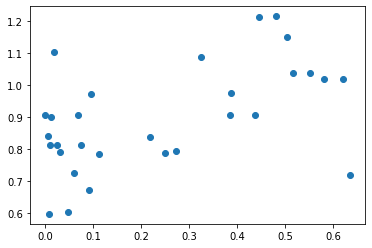

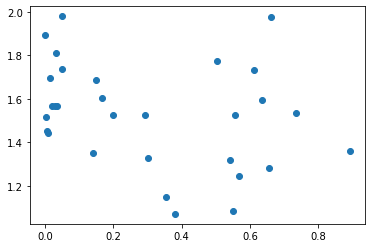

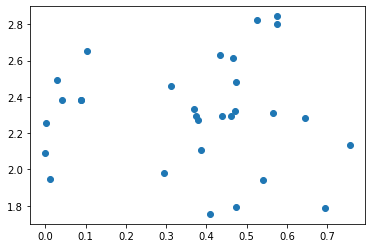

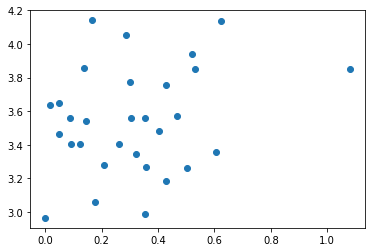

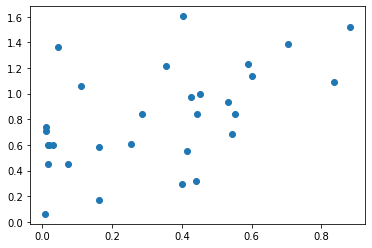

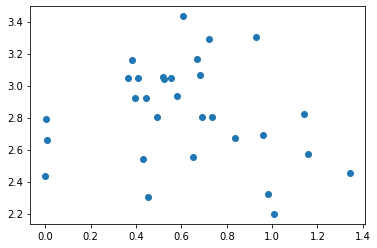

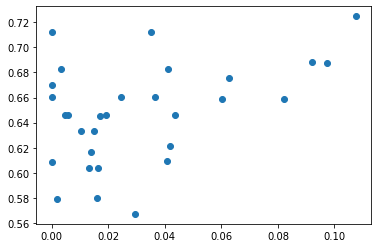

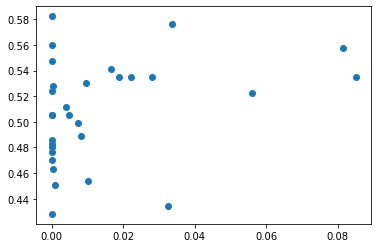

In [30]:
import matplotlib.pyplot as plt
y_pred = pd.DataFrame(y_pred, columns=y.columns)
for Y in y:
    plt.scatter(y[Y], y_pred[Y])
    plt.show()

In [31]:
res={}
coef={}
for Y in y:
    modelq.fit(Xpoly, y[Y])
    res[Y] = modelq.score(Xpoly, y[Y])
    coef[Y] = modelq.coef_


In [32]:
print(res)


{'X10 1': 0.6247095604955781, 'C3 1570': 0.5502951143971733, 'X10 1500/1': 0.6398738432885416, 'C1 1500/1': 0.5911491277787115, 'Hel1': 0.6582582334051885, 'C3 0614/2': 0.7850895478476856, 'PR1 FL': 0.8971092755057224, 'PR1 0120/1': 0.7443513402059434}


In [33]:
y_pred

,X10 1,C3 1570,X10 1500/1,C1 1500/1,Hel1,C3 0614/2,PR1 FL,PR1 0120/1
0,1.150266,1.317678,2.803462,4.134739,1.388719,3.290143,0.621488,0.479970
1,0.717737,1.974482,1.941989,3.260174,0.321631,2.538203,0.724800,0.576454
2,1.104497,1.083739,2.653893,3.857332,1.360403,3.068813,0.567239,0.434328
3,0.671535,1.735994,1.795374,2.985238,0.297851,2.321199,0.669858,0.530398
4,1.038014,1.070953,2.612453,3.937597,1.228116,3.053368,0.609452,0.463419
5,0.604242,1.730438,1.754758,3.059263,0.167215,2.305726,0.711957,0.559702
6,1.216262,1.329659,2.843915,4.054041,1.520696,3.305031,0.579398,0.450874
7,0.784542,1.979233,1.981617,3.185716,0.451956,2.553119,0.682825,0.547145
8,1.037065,1.244699,2.824859,3.850090,1.139668,3.433162,0.608773,0.486152
9,0.597003,1.894089,1.948570,2.964628,0.062125,2.657856,0.712007,0.582429
